# Dog Identification App 2

I had problems saving the original dog_app.ipynb probably due to file size, so have created this to notebook to hold some of the peripheral cells

### Imports

In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
import pandas as pd
from glob import glob
import tensorflow as tf
import cv2
import PIL
import os
import time
import sys
import matplotlib.pyplot as plt
import csv
import pickle

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import keras.backend as K
import keras
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import Conv2D
from keras.optimizers import SGD,RMSprop,adam
from keras.callbacks import ModelCheckpoint  
from keras import callbacks
from keras import Input

Using TensorFlow backend.


### Load Dataset

In [2]:
# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('../../../data/dog_images/train')
valid_files, valid_targets = load_dataset('../../../data/dog_images/valid')
test_files, test_targets = load_dataset('../../../data/dog_images/test')

# load list of dog names
dog_names = [item[35:-1] for item in sorted(glob("../../../data/dog_images/train/*/"))]
num_classes=133

In [3]:
# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))
print('')
print('tensorflow version',tf.__version__)
print('keras version',keras.__version__)
print('python version',sys.version_info)

There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.

tensorflow version 1.3.0
keras version 2.0.9
python version sys.version_info(major=3, minor=6, micro=3, releaselevel='final', serial=0)


In [4]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("../../../data/lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d human images in total.' % len(human_files))

There are 13233 human images in total.


## Exploration the Dog Breed Classes

In [5]:
# Add all targets into one list
dog_targets_all=[]
dog_targets_all.extend(train_targets)
dog_targets_all.extend(valid_targets)
dog_targets_all.extend(test_targets)


In [6]:
# Index of each breed in dog_names list for each image
class_labels = np.argmax(dog_targets_all, axis=1) 
class_labels

array([ 94,  56,  87, ...,  90,  80, 101])

In [7]:
class_label_counts = dict()
for i in class_labels:
    class_label_counts[i] = class_label_counts.get(i, 0) + 1
    
class_label_counts_df = pd.DataFrame(list(class_label_counts.values()), index=class_label_counts.keys(),columns=['count'])
class_label_counts_df = class_label_counts_df.sort_index(axis=0,level=None, ascending=True)

class_label_counts_df.describe()

,count
count,133.000000
mean,62.789474
std,14.852330
min,33.000000
25%,53.000000
50%,62.000000
75%,76.000000
max,96.000000


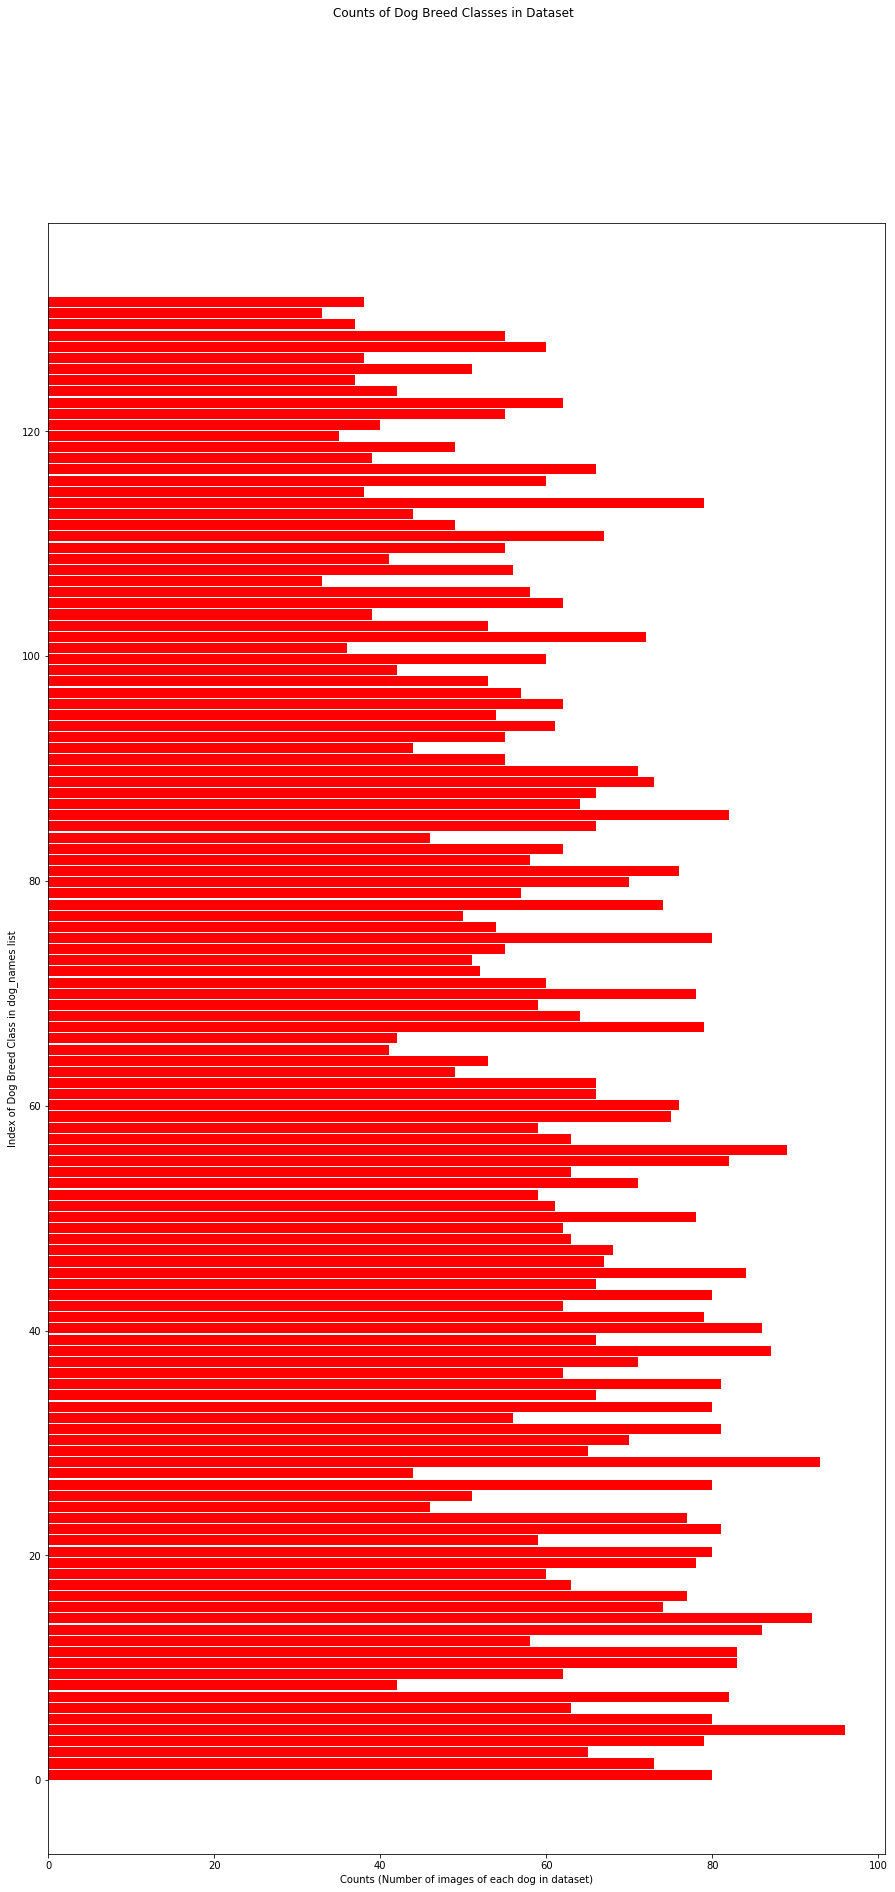

In [8]:
# Plot class labels as a histogram
fig, axs = plt.subplots(figsize=(15,30))

axs = plt.hist(class_labels, orientation='horizontal',color='red', rwidth=0.9 ,bins=133)

fig.suptitle('Counts of Dog Breed Classes in Dataset')
plt.xlabel('Counts (Number of images of each dog in dataset)')
plt.ylabel('Index of Dog Breed Class in dog_names list')
plt.savefig('class_histogram.png')

plt.show()

So the dog breed classes are imbalanced in the dataset.

In [9]:
np.savetxt("class_labels.csv", class_labels.astype('int'), delimiter=",")

## Step1.  (Optional) TODO: Report the performance of another face detection algorithm on the LFW dataset

In [10]:
pathname='./history/Step1_Opt_trainHistoryDict.npy'
history=np.load(pathname,allow_pickle='TRUE').item()

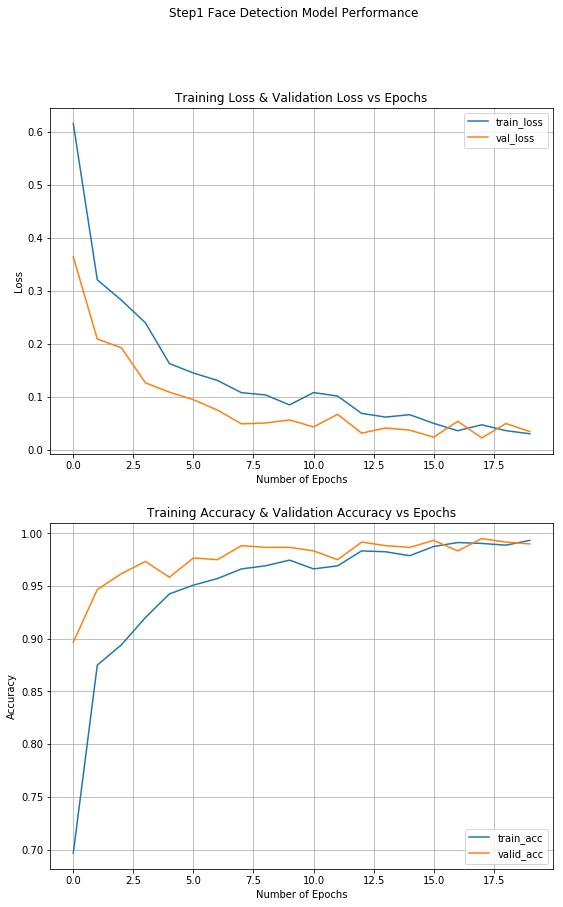

In [11]:
# Plot the loss and accuracy curves
num_epoch=20
train_loss=history['loss']
valid_loss=history['val_loss']
train_acc=history['acc']
valid_acc=history['val_acc']
x_range=range(num_epoch)

fig,axs = plt.subplots(2,figsize=(9,14))
fig.suptitle('Step1 Face Detection Model Performance')
fig.patch.set_facecolor('w')

axs[0].plot(x_range,train_loss)
axs[0].plot(x_range,valid_loss)
axs[0].set_xlabel('Number of Epochs')
axs[0].set_ylabel('Loss')
axs[0].set_title('Training Loss & Validation Loss vs Epochs')
axs[0].grid(True)
axs[0].legend(['train_loss','val_loss'])
axs[0].set_facecolor('w')

axs[1].plot(x_range,train_acc)
axs[1].plot(x_range,valid_acc)
axs[1].set_xlabel('Number of Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('Training Accuracy & Validation Accuracy vs Epochs')
axs[1].grid(True)
axs[1].legend(['train_acc','valid_acc'],loc=4)

plt.show()

## Step 3. Create a CNN to Classify Dog Breeds (from Scratch)

In [12]:
pathname='./history/Step3_trainHistoryDict.npy'
history=np.load(pathname,allow_pickle='TRUE').item()

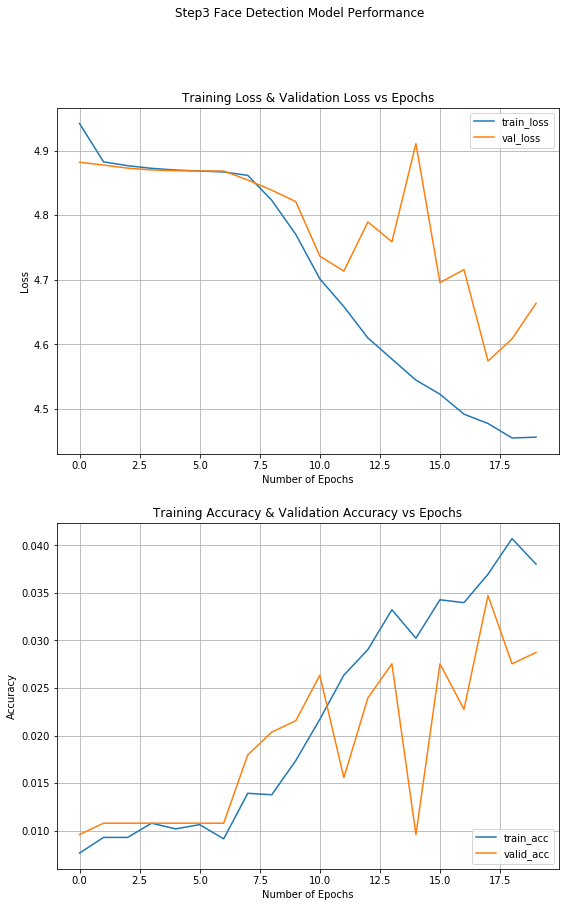

In [13]:
# Plot the loss and accuracy curves
num_epoch=20
train_loss=history['loss']
valid_loss=history['val_loss']
train_acc=history['acc']
valid_acc=history['val_acc']
x_range=range(num_epoch)

fig,axs = plt.subplots(2,figsize=(9,14))
fig.suptitle('Step3 Face Detection Model Performance')
fig.patch.set_facecolor('w')

axs[0].plot(x_range,train_loss)
axs[0].plot(x_range,valid_loss)
axs[0].set_xlabel('Number of Epochs')
axs[0].set_ylabel('Loss')
axs[0].set_title('Training Loss & Validation Loss vs Epochs')
axs[0].grid(True)
axs[0].legend(['train_loss','val_loss'])
axs[0].set_facecolor('w')

axs[1].plot(x_range,train_acc)
axs[1].plot(x_range,valid_acc)
axs[1].set_xlabel('Number of Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('Training Accuracy & Validation Accuracy vs Epochs')
axs[1].grid(True)
axs[1].legend(['train_acc','valid_acc'],loc=4)

plt.show()

## Step4.  Using a CNN to Classify Dog Breeds using transfer learning  VGG-16

In [14]:
pathname='./history/Step4_trainHistoryDict.npy'
history=np.load(pathname,allow_pickle='TRUE').item()

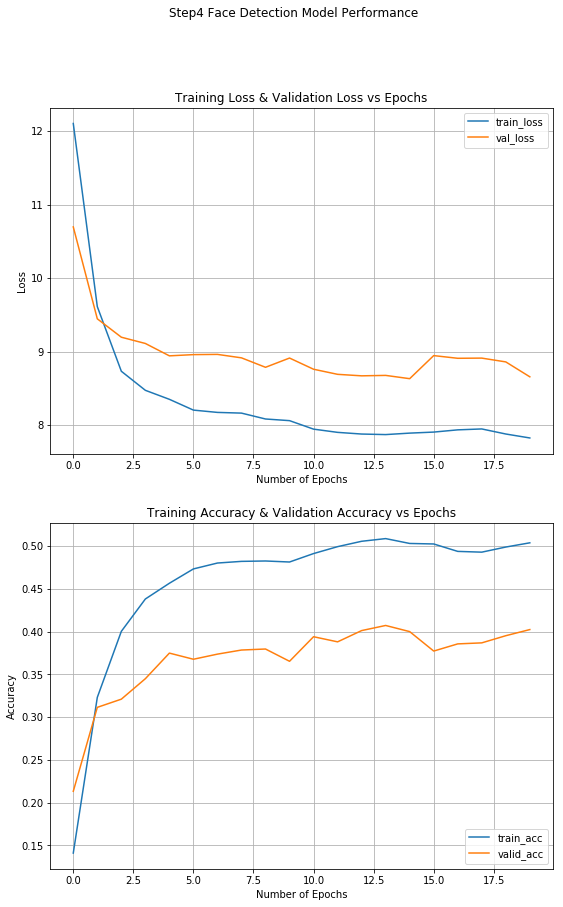

In [15]:
# Plot the loss and accuracy curves
num_epoch=20
train_loss=history['loss']
valid_loss=history['val_loss']
train_acc=history['acc']
valid_acc=history['val_acc']
x_range=range(num_epoch)

fig,axs = plt.subplots(2,figsize=(9,14))
fig.suptitle('Step4 Face Detection Model Performance')
fig.patch.set_facecolor('w')

axs[0].plot(x_range,train_loss)
axs[0].plot(x_range,valid_loss)
axs[0].set_xlabel('Number of Epochs')
axs[0].set_ylabel('Loss')
axs[0].set_title('Training Loss & Validation Loss vs Epochs')
axs[0].grid(True)
axs[0].legend(['train_loss','val_loss'])
axs[0].set_facecolor('w')

axs[1].plot(x_range,train_acc)
axs[1].plot(x_range,valid_acc)
axs[1].set_xlabel('Number of Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('Training Accuracy & Validation Accuracy vs Epochs')
axs[1].grid(True)
axs[1].legend(['train_acc','valid_acc'],loc=4)

plt.show()

## Step 5. Using a CNN to Classify Dog Breeds using transfer learning Resnet-50

In [16]:
pathname='./history/Step5_trainHistoryDict.npy'
history=np.load(pathname,allow_pickle='TRUE').item()

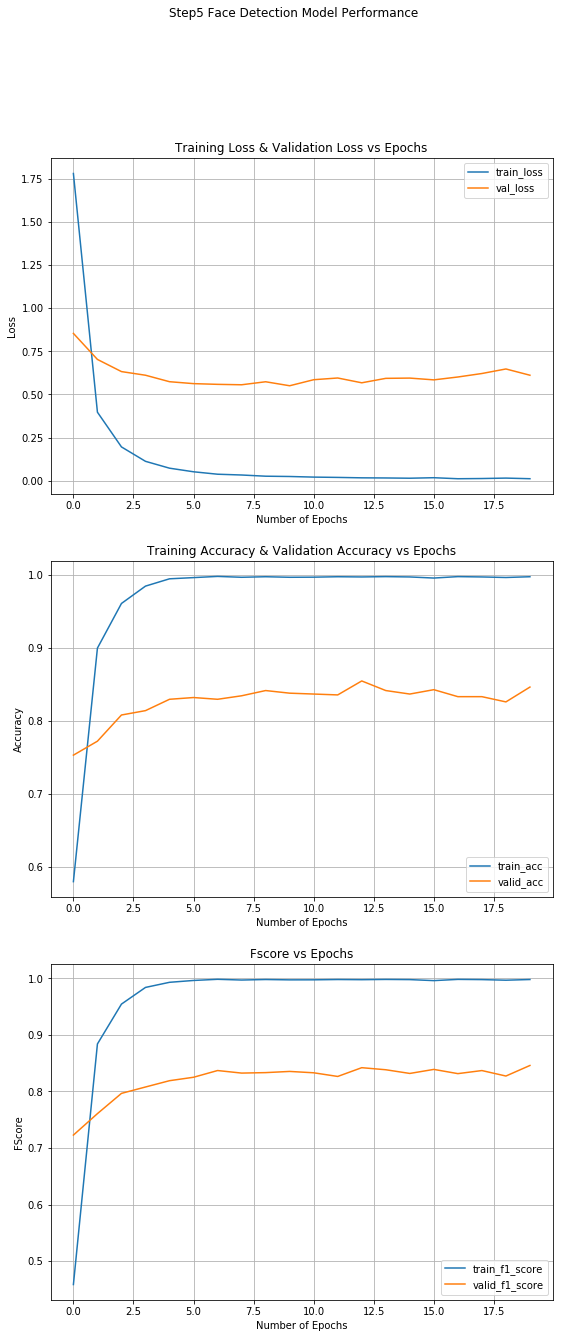

In [17]:
# Plot the loss and accuracy curves
num_epoch=20
train_loss=history['loss']
valid_loss=history['val_loss']
train_acc=history['acc']
valid_acc=history['val_acc']
train_f1score=history['f1_score']
valid_f1score=history['val_f1_score']
x_range=range(num_epoch)

fig,axs = plt.subplots(3,figsize=(9,21))
fig.suptitle('Step5 Face Detection Model Performance')
fig.patch.set_facecolor('w')

axs[0].plot(x_range,train_loss)
axs[0].plot(x_range,valid_loss)
axs[0].set_xlabel('Number of Epochs')
axs[0].set_ylabel('Loss')
axs[0].set_title('Training Loss & Validation Loss vs Epochs')
axs[0].grid(True)
axs[0].legend(['train_loss','val_loss'])
axs[0].set_facecolor('w')

axs[1].plot(x_range,train_acc)
axs[1].plot(x_range,valid_acc)
axs[1].set_xlabel('Number of Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('Training Accuracy & Validation Accuracy vs Epochs')
axs[1].grid(True)
axs[1].legend(['train_acc','valid_acc'],loc=4)


axs[2].plot(x_range,train_f1score)
axs[2].plot(x_range,valid_f1score)
axs[2].set_xlabel('Number of Epochs')
axs[2].set_ylabel('FScore')
axs[2].set_title('Fscore vs Epochs')
axs[2].grid(True)
axs[2].legend(['train_f1_score','valid_f1_score'],loc=4)

plt.show()

## Step5 CNN to Classify Dog Breeds using transfer learning Resnet-50 Confusion Matrix

In [18]:
pathname='./history/Step5_y_true.npy'
test_classes=np.load(pathname,allow_pickle='TRUE')
pathname='./history/Step5_y_pred.npy'
model2_preds=np.load(pathname,allow_pickle='TRUE')

In [19]:
# Confusion Matrix   Rows are test classes Columns are predictions
con_matrix=confusion_matrix(y_true=test_classes, y_pred= model2_preds,  labels=None, sample_weight=None)

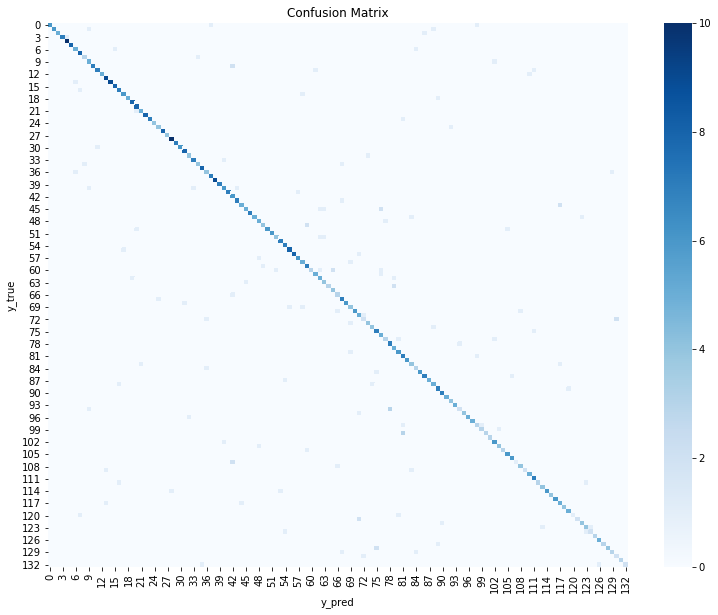

In [20]:
import seaborn as sns; 

fig= plt.figure(figsize=(13,10))
axs = plt.axes()
fig.add_axes(axs)
axs.set_title('Confusion Matrix')
sns.heatmap(con_matrix, annot=False, cmap="Blues", ax=axs)
plt.xlabel('y_pred')
plt.ylabel('y_true')
plt.show()

In [21]:
cm_df=pd.DataFrame(con_matrix)
con_matrix2=con_matrix.copy()



def get_name(indx):
    """
    Get the dog breed for an index
    Args:
    indx(indx): index of dog breed name
    """
    return dog_names[indx]



error_df = pd.DataFrame(columns=['x_index','y_index','count'])

for x in range(0,133):
    for y in range(0,133):
        if(x!=y and con_matrix[x,y]!=0):
            #print(x,y,con_matrix[x,y])
            error_df= error_df.append({'x_index':x,'y_index':y,'count':con_matrix[x,y]}, ignore_index=True)
        else:
            con_matrix2[x,y]=0



repeated_errors=error_df.sort_values(['count'],ascending=False).head(20)
repeated_errors['x_name'] = repeated_errors['x_index'].apply(lambda x : get_name(x)) 
repeated_errors['y_name'] = repeated_errors['y_index'].apply(lambda y : get_name(y)) 

In [22]:
repeated_errors

,x_index,y_index,count,x_name,y_name
93,100,81,3,Maltese,Havanese
87,94,78,3,Kuvasz,Great_pyrenees
36,45,76,2,Cavalier_king_charles_spaniel,Gordon_setter
52,60,65,2,English_cocker_spaniel,Field_spaniel
109,121,71,2,Pointer,German_shorthaired_pointer
97,107,42,2,Norwegian_buhund,Canaan_dog
40,49,59,2,Chinese_shar-pei,Dogue_de_bordeaux
10,10,42,2,Australian_cattle_dog,Canaan_dog
58,64,79,2,Entlebucher_mountain_dog,Greater_swiss_mountain_dog
116,128,75,2,Tibetan_mastiff,Golden_retriever


In [23]:
for index, row in repeated_errors.head(5).iterrows():
    msg_part1='Predicted dog was a {x_name}, but really it was a {y_name}, {count} times.'
    msg=msg_part1.format(x_name=row['x_name'], y_name=row['y_name'], count=row['count'])
    print(msg)

Predicted dog was a Maltese, but really it was a Havanese, 3 times.
Predicted dog was a Kuvasz, but really it was a Great_pyrenees, 3 times.
Predicted dog was a Cavalier_king_charles_spaniel, but really it was a Gordon_setter, 2 times.
Predicted dog was a English_cocker_spaniel, but really it was a Field_spaniel, 2 times.
Predicted dog was a Pointer, but really it was a German_shorthaired_pointer, 2 times.


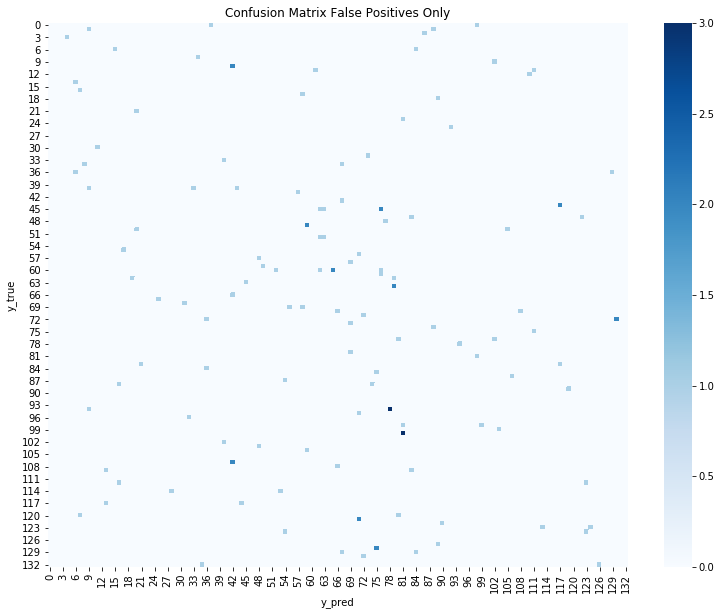

In [24]:
# Confusion Matrix False Positives only
fig= plt.figure(figsize=(13,10))
axs = plt.axes()
fig.add_axes(axs)
axs.set_title('Confusion Matrix False Positives Only')
sns.heatmap(con_matrix2, annot=False, cmap="Blues", ax=axs)
plt.xlabel('y_pred')
plt.ylabel('y_true')
plt.show()